# Exercício de classificação de textos com LLM

## Visão Geral

Este exercício busca explorar técnicas mais avançadas de classificação de texto com modelos de linguagem.
Você utilizará um conjunto de dados multiclasse do Kaggle, implementará abordagens de zero-shot, few-shot, chain of tought e guard rails e comparará a eficácia de cada uma.




# Classificação multiclasse com um dataset do Kaggle

LInk para baixar o dataset no kaggle:

- **[Link](https://www.kaggle.com/datasets/diogocaliman/notcias-publicadas-no-brasil)**: Após clicar no link basta rolar a página um pouco para baixo e achar o botão de download mais a direita

O dataset “Notícias Publicadas no Brasil” reúne milhares de notícias de portais brasileiros, categorizadas por tema. Ele foi construído para tarefas de classificação de texto e análise de conteúdo jornalístico, sendo ideal para projetos de processamento de linguagem natural (PLN) em português.

📊 Estrutura dos dados

Cada linha do dataset representa uma notícia e contém, em geral, as seguintes colunas:

titulo — título da notícia.

texto — conteúdo completo da notícia.

categoria — rótulo de classificação que indica o tema principal da notícia.

🏷️ Categorias

As notícias são divididas em cinco grandes classes temáticas, o que torna o dataset adequado para classificação multiclasse.
As categorias são:

- Política
- Esportes
- Economia
- Tecnologia
- Famosos



## Preparando o ambiente 

In [2]:
!pip install -q "langchain==0.3.27" langchain-openai pandas matplotlib seaborn scikit-learn

In [3]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import Runnable
from langchain.schema.runnable.config import RunnableConfig
from langchain_huggingface import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import List

c:\Users\danie\OneDrive\Área de Trabalho\UFMG\MonitoraSB\monitoria\.venvmonitoria\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Download and load your chosen dataset
df = pd.read_csv("data/Historico_de_materias.csv")


df = df.rename(columns={'Class Index':'category'})


# Display examples of each class
for category in df['category'].unique():
    print(f"\n--- Examples of '{category}' class ---")
    print(df[df['category'] == category]['title'].head(2).values)


--- Examples of 'economia' class ---
['Mesmo com alta do dólar, gastos de brasileiros no exterior batem recorde'
 "Para Dilma, é 'apressada' a tese de que emergentes perderão dinamismo"]

--- Examples of 'esportes' class ---
["Belfort concorre a prêmio de melhor lutador do ano no 'Oscar do MMA'"
 'Nadal precisa de mais de duas horas para vencer número 74 do mundo']

--- Examples of 'politica' class ---
["Dilma diz no Twitter que acompanha crise no Maranhão 'com atenção'"
 'CGU suspende declaração de inidoneidade da Delta e de subsidiária']

--- Examples of 'famosos' class ---
['Camila Queiroz posa com cachorro e arranca elogios da web'
 "Juliana Paes posa de maiô, exibe boa forma e brinca: 'Aja naturalmente'"]

--- Examples of 'tecnologia' class ---
['Ações da Apple despencam após anúncio de menor faturamento'
 'Blockchain: tecnologia que irá revolucionar a integração de dados distribuídos globalmente será destaque em 2019']


# 1. Classificação Zero-shot 

Use o modelo FLAN-T5 (ou outro de sua escolha) para classificar textos sem fornecer exemplos. Crie um prompt que descreva claramente cada categoria.

In [ ]:
# Choose a model that's good for both conversation and classification
os.environ["OPENAI_API_KEY"] = ""

# Cria o LLM da OpenAI (você pode usar gpt-4o-mini, gpt-4-turbo, ou gpt-3.5-turbo)
llm = ChatOpenAI(
    model="gpt-4o-mini",   # ou "gpt-4-turbo"
    temperature=0.2
)

# Step 6: Run a classification on a sample of the data
def classify_texts(texts: List[str], chain: Runnable) -> List[str]:
    """Classify a list of texts using the provided chain."""
    results = []
    for text in texts:
        result = chain.invoke({"text": text})
        results.append(result.strip())
    return results


In [6]:
# Create a zero-shot classification prompt
zero_shot_template = """
Classifique as manchetes a seguir em exatamente uma destas categorias:
- "esportes"
- "economia"
- "politica"
- "tecnologia"
- "famosos"

Texto: {text}

Classificação:

"""

# Create and test the zero-shot classification chain
zero_shot_prompt = ChatPromptTemplate.from_template(zero_shot_template)
zero_shot_chain = zero_shot_prompt | llm | StrOutputParser()

# Classify a sample of texts
# seleciona até 10 exemplos por categoria (50 exemplos no total)
sample_indices = (
    df.groupby('category', group_keys=False)
      .apply(lambda x: x.sample(min(len(x), 10), random_state=42))
      .index
)

zero_shot_predictions = classify_texts(df.loc[sample_indices, 'title'], zero_shot_chain)

C:\Users\danie\AppData\Local\Temp\ipykernel_18552\2092456625.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), 10), random_state=42))



# 2. Classificação Few-shot
Aprimore o prompt com exemplos de cada categoria para ajudar o modelo a entender melhor a tarefa de clasisficação.


In [7]:
# Create a few-shot classification prompt with examples
few_shot_template = """
Classifique as manchetes a seguir em exatamente uma destas categorias:
Escolha apenas a categoria mais adequada e responda SOMENTE com o nome da categoria.

CATEGORIAS (responda exatamente como escrito):
- "esportes": textos sobre competições esportivas, jogos, atletas ou condicionamento físico
- "economia": textos sobre finanças, negócios, mercado, empresas ou economia em geral
- "politica": textos sobre governo, eleições, políticas públicas ou assuntos políticos
- "tecnologia": textos sobre inovações, internet, softwares, dispositivos ou ciência aplicada
- "famosos": textos sobre celebridades, cultura pop, entretenimento ou vida de pessoas públicas

EXEMPLOS:
Exemplo 1:
"Belfort concorre a prêmio de melhor lutador do ano no 'Oscar do MMA"
Classificação: esportes

Exemplo 2:
"Mesmo com alta do dólar, gastos de brasileiros no exterior batem recorde"
Classificação: economia

Exemplo 3:
"Dilma diz no Twitter que acompanha crise no Maranhão 'com atenção'"
Classificação: politica

Exemplo 4:
"Blockchain: tecnologia que irá revolucionar a integração de dados distribuídos globalmente será destaque em 2019"
Classificação: tecnologia

Exemplo 5:
"Camila Queiroz posa com cachorro e arranca elogios da web"
Classificação: famosos


Texto para classificar: {text}

Classificação:
"""

# Create and test the few-shot classification chain
few_shot_prompt = ChatPromptTemplate.from_template(few_shot_template)
few_shot_chain = few_shot_prompt | llm | StrOutputParser()

# Classify the same sample of texts
few_shot_predictions = classify_texts(df.loc[sample_indices, 'title'], few_shot_chain)

# 3. Classificação com mais de uma técnica de prompting

Nesta abordagem, a ideia é fazer um mix de técnicas vistas na aula. Comecei dando um contexto, deixei regras bem claras a serem seguidas (guard rails) e dei alguns exemplos (few shot)

In [8]:
# Create a few-shot classification prompt with examples
mix_template = """
Você é um classificador de manchetes. Sua tarefa é identificar a categoria correta para cada texto.

REGRAS (siga à risca):
1) Leia o texto com atenção.
2) Selecione a ÚNICA categoria que melhor descreve o conteúdo.
3) Responda APENAS com: esportes, economia, politica, tecnologia ou famosos.
4) Não inclua explicações adicionais.

CATEGORIAS (responda exatamente como escrito):
- "esportes": textos sobre competições esportivas, jogos, atletas ou condicionamento físico
- "economia": textos sobre finanças, negócios, mercado, empresas ou economia em geral
- "politica": textos sobre governo, eleições, políticas públicas ou assuntos políticos
- "tecnologia": textos sobre inovações, internet, softwares, dispositivos ou ciência aplicada
- "famosos": textos sobre celebridades, cultura pop, entretenimento ou vida de pessoas públicas

EXEMPLOS:
Exemplo 1:
"Com gol no fim, o time garantiu vaga na final do campeonato nacional; técnico elogia preparo físico do elenco."
Classificação: esportes

Exemplo 2:
"A bolsa abriu em alta após dados de inflação abaixo do esperado; ações de bancos e varejo lideram os ganhos."
Classificação: economia

Exemplo 3:
"O congresso aprovou a nova reforma eleitoral após longo debate; governo articula próximos passos com líderes partidários."
Classificação: politica

Exemplo 4:
"A startup lançou um modelo de IA que reduz o consumo de energia em data centers e acelera o treinamento de redes neurais."
Classificação: tecnologia

Exemplo 5:
"A atriz comentou nas redes sociais sobre seu novo filme e apareceu ao lado de outros artistas em evento de estreia."
Classificação: famosos

Texto para classificar: {text}

Classificação:
"""

# Create and test the few-shot classification chain
mix_prompt = ChatPromptTemplate.from_template(mix_template)
mix_chain = mix_prompt | llm | StrOutputParser()

# Classify the same sample of texts
mix_predictions = classify_texts(df.loc[sample_indices, 'title'], mix_chain)

# 4. Avaliar e comparar as abordagens

Crie funções de avaliação que funcionem com classificação multiclasse.


In [9]:
# Define the mapping from text predictions to class indices
def map_predictions_to_classes(predictions, class_mapping):
    """
    Map text predictions to class indices based on the mapping dictionary

    Parameters:
    predictions (list): List of text predictions from the model
    class_mapping (dict): Dictionary mapping class names to indices

    Returns:
    list: Mapped numerical class indices
    """
    mapped_predictions = []

    for pred in predictions:
        # Clean and lowercase the prediction
        pred = pred.lower().strip()

        # Try to find direct matches first
        matched = False
        for class_name, idx in class_mapping.items():
            if class_name.lower() in pred:
                mapped_predictions.append(idx)
                matched = True
                break

        # If no direct match, find the most likely class
        if not matched:
            # Default to the first class if no match is found
            mapped_predictions.append(0)
            print(f"Warning: Could not match prediction '{pred}' to any class. Defaulting to class 0.")

    return mapped_predictions


# Modify the evaluation functions for multi-class classification
def evaluate_multiclass(y_true, y_pred, classes):
    """Evaluate multi-class classification results"""
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Print classification report
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=classes))

    # Create and display confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return accuracy

=== ZERO-SHOT ===
Accuracy: 0.9200

Classification Report:
              precision    recall  f1-score   support

    economia       1.00      0.80      0.89        10
    esportes       1.00      0.90      0.95        10
     famosos       0.83      1.00      0.91        10
    politica       0.83      1.00      0.91        10
  tecnologia       1.00      0.90      0.95        10

    accuracy                           0.92        50
   macro avg       0.93      0.92      0.92        50
weighted avg       0.93      0.92      0.92        50



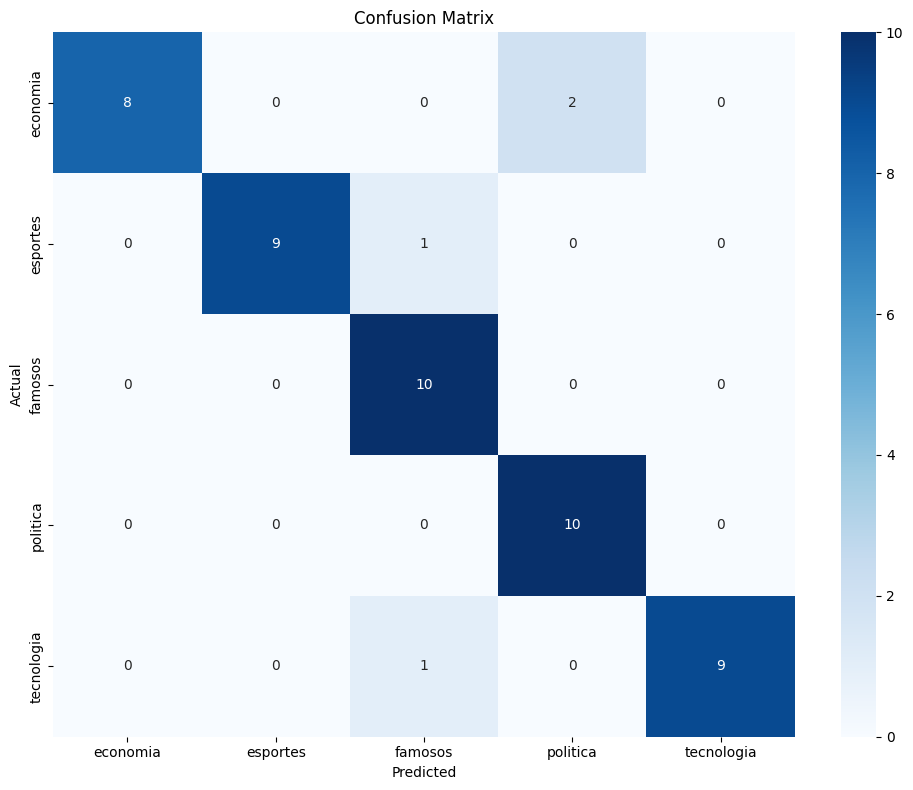


=== FEW-SHOT ===
Accuracy: 0.8400

Classification Report:
              precision    recall  f1-score   support

    economia       1.00      0.70      0.82        10
    esportes       1.00      0.60      0.75        10
     famosos       1.00      1.00      1.00        10
    politica       0.59      1.00      0.74        10
  tecnologia       0.90      0.90      0.90        10

    accuracy                           0.84        50
   macro avg       0.90      0.84      0.84        50
weighted avg       0.90      0.84      0.84        50



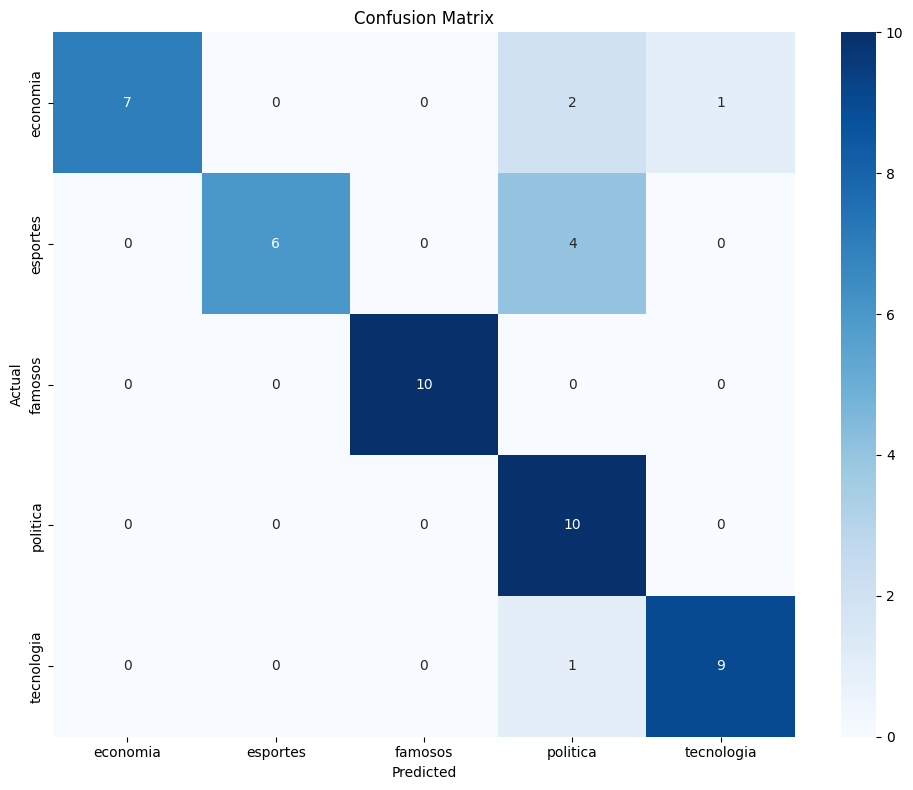


=== MIX ===
Accuracy: 0.8200

Classification Report:
              precision    recall  f1-score   support

    economia       0.88      0.70      0.78        10
    esportes       1.00      0.60      0.75        10
     famosos       0.83      1.00      0.91        10
    politica       0.67      1.00      0.80        10
  tecnologia       0.89      0.80      0.84        10

    accuracy                           0.82        50
   macro avg       0.85      0.82      0.82        50
weighted avg       0.85      0.82      0.82        50



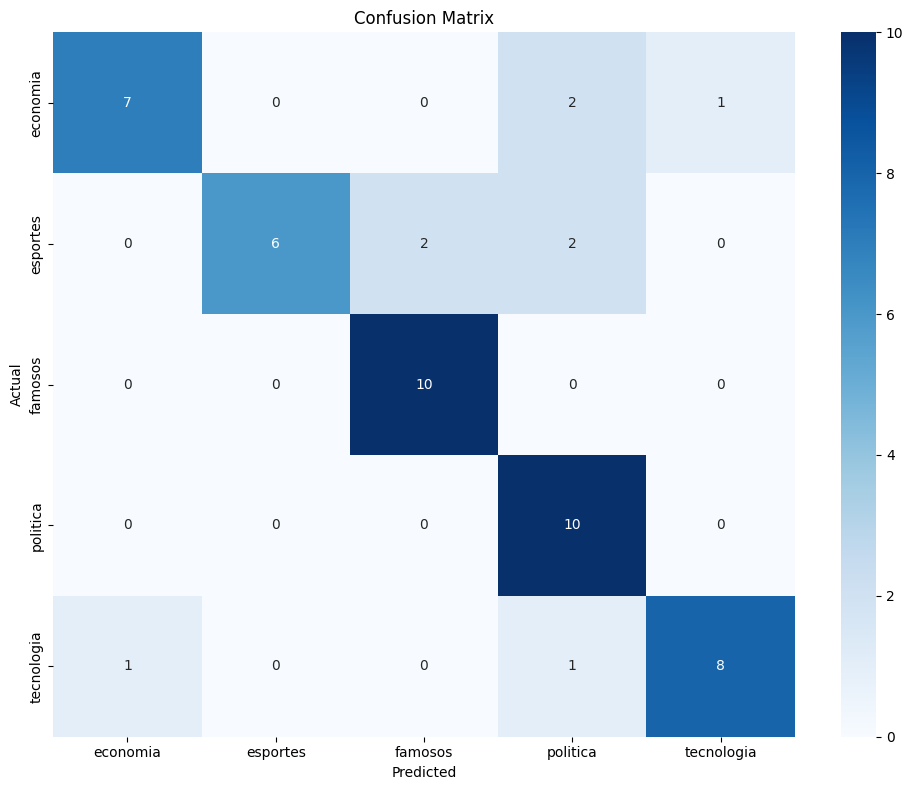

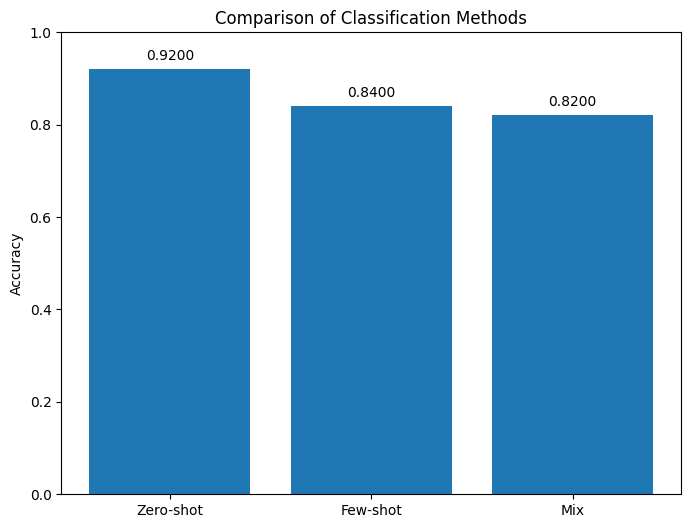

In [10]:
# Define class mapping (adjust according to your dataset)
classes = sorted(df['category'].unique())
class_mapping = {class_name: idx for idx, class_name in enumerate(classes)}

# Get true labels from the dataset
true_labels = [class_mapping[label] for label in df.loc[sample_indices, 'category']]

# Compare zero-shot and few-shot results
print("=== ZERO-SHOT ===")
zero_shot_mapped = map_predictions_to_classes(zero_shot_predictions, class_mapping)
zero_shot_accuracy = evaluate_multiclass(true_labels, zero_shot_mapped, classes)

print("\n=== FEW-SHOT ===")
few_shot_mapped = map_predictions_to_classes(few_shot_predictions, class_mapping)
few_shot_accuracy = evaluate_multiclass(true_labels, few_shot_mapped, classes)

print("\n=== MIX ===")
mix_mapped = map_predictions_to_classes(mix_predictions, class_mapping)
mix_accuracy = evaluate_multiclass(true_labels, mix_mapped, classes)

# Visualize the comparison
plt.figure(figsize=(8, 6))
accuracies = [zero_shot_accuracy, few_shot_accuracy, mix_accuracy]
methods = ['Zero-shot', 'Few-shot', 'Mix']
plt.bar(methods, accuracies)
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Comparison of Classification Methods')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center')
plt.show()